In [1]:
from torchvision import transforms
from torch.utils.data import random_split
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader
import torch
from PIL import Image
import os
import random
from torchvision import transforms
from torch.utils.data import Dataset
import math
import timm
from torchvision.datasets import ImageFolder
from torch.optim import RMSprop
from torch.optim.lr_scheduler import ReduceLROnPlateau

def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

    # For deterministic behavior
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


## Loading dataset

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("salader/dogs-vs-cats")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [3]:
def get_images_data(is_train_folder, is_dog, base_path=path):
    # Construct folder path
    if is_train_folder:
        folder_path = os.path.join(base_path, "train", "dogs" if is_dog else "cats")
    else:
        folder_path = os.path.join(base_path, "test", "dogs" if is_dog else "cats")

    def load_image_ids(folder, label):
        imgs_list = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img_id = os.path.splitext(filename)[0]
            imgs_list.append((img_path, int(label), img_id))  # store path instead of tensor
        return imgs_list

    imgs_data = load_image_ids(folder_path, is_dog)
    return imgs_data  # list of (img_path, label, img_id)


In [4]:
train_dog_data = get_images_data(is_train_folder=True, is_dog=True)
print(len(train_dog_data))

10000


# Augmnetaion

In [5]:

def get_augmented_img(img_tensor):
    """
    Applies 2D augmentations (flip, scale, translate, rotate, and noise) to an image tensor.

    Args:
        img_tensor (torch.Tensor): Input image tensor of shape (1, C, H, W)

    Returns:
        torch.Tensor: Augmented image tensor of the same shape (1, C, H, W)
    """
    augmentation_dict = {
    'flip': True, # Flips the image either horizontally or vertically.
    'offset': 0.1,# Moves the image by a fraction of its size (0.1 means 10% shift).
    'scale': 0.2, # Zoom In/Out
    'rotate': True, # Rotates the image by a random degree.
    'noise': 0.05  # Noise should be a small fraction (e.g., 0.05 instead of 25.0)
}

    img_tensor = img_tensor.unsqueeze(0)
    device = img_tensor.device
    transform_t = torch.eye(3, dtype=torch.float32, device=device)  # 3×3 affine matrix

    # Horizontal and Vertical Flip
    if augmentation_dict.get('flip', False):
        if random.random() > 0.5:
            transform_t[0, 0] *= -1  # Flip horizontally

        if random.random() > 0.5:
            transform_t[1, 1] *= -1  # Flip vertically

    # Translation (Offset)
    if 'offset' in augmentation_dict:
        offset_val = augmentation_dict['offset']
        transform_t[0, 2] = (random.random() * 2 - 1) * offset_val  # X-axis translation
        transform_t[1, 2] = (random.random() * 2 - 1) * offset_val  # Y-axis translation

    # Scaling
    if 'scale' in augmentation_dict:
        scale_val = augmentation_dict['scale']
        scale_factor = 1.0 + (random.random() * 2 - 1) * scale_val
        transform_t[0, 0] *= scale_factor
        transform_t[1, 1] *= scale_factor

    # Rotation
    if 'rotate' in augmentation_dict:
        angle_rad = (random.random() * 2 - 1) * math.pi / 4  # Random angle between -45° and 45°
        cos_a, sin_a = math.cos(angle_rad), math.sin(angle_rad)

        rotation_t = torch.tensor([
            [cos_a, -sin_a, 0],
            [sin_a,  cos_a, 0],
            [0,      0,     1]
        ], dtype=torch.float32, device=device)

        transform_t = rotation_t @ transform_t  # Apply rotation

    # Convert to (1,2,3) matrix for affine_grid
    affine_t = transform_t[:2].unsqueeze(0)  # Shape (1, 2, 3)

    # Generate grid for transformation
    grid = F.affine_grid(affine_t, img_tensor.size(), align_corners=False)

    # Apply the transformation
    augmented_img = F.grid_sample(img_tensor, grid, padding_mode='border', align_corners=False)

    # Add noise
    if 'noise' in augmentation_dict:
        noise_std = augmentation_dict['noise'] * torch.std(img_tensor)  # Scale noise based on image contrast
        noise = torch.randn_like(augmented_img, device=device) * noise_std
        augmented_img += noise

    return augmented_img.squeeze(0).clamp(0, 1)  # Keep pixel values in valid range
    # return the full tensor including batch diememsion (1,3,224,224)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, is_val=None, is_test=None, val_stride=5, use_augmenatation=True):
        self.is_test=is_test
        self.is_val=is_val
        self.dog_list=None
        self.cat_list=None
        self.use_augmentaion=use_augmenatation

        if (is_test):
            self.dog_list=get_images_data(is_train_folder=False,is_dog=True) # get positive samples from test folder
            self.cat_list=get_images_data(is_train_folder=False,is_dog=False) # get negative samples from test folder
            assert self.dog_list and self.cat_list

        else: # train & validation
            self.dog_list=get_images_data(is_train_folder=True,is_dog=True) # get all positive samples from train folder
            self.cat_list=get_images_data(is_train_folder=True,is_dog=False) # get all negative samples from train folder

            assert val_stride > 0 and val_stride

            if(is_val): # validation set
                self.dog_list=self.dog_list[::val_stride]
                self.cat_list=self.cat_list[::val_stride]
                assert self.dog_list and self.cat_list
            else: # train set
                del self.dog_list[::val_stride]
                del self.cat_list[::val_stride]
                assert self.dog_list and self.cat_list

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def load_and_transform_image(self, img_path):
        try:
            img = Image.open(img_path).convert("RGB")
            return self.transform(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return torch.zeros((3, 224, 224))  # fallback in case of error

    def shuffleSamples(self): #  We will call this at the top of each epoch to randomize the order of samples being presented.
        random.shuffle(self.cat_list)
        random.shuffle(self.dog_list)

    def __len__(self):
        if(self.is_test or self.is_val or not self.use_augmentaion):
            return len(self.cat_list)+ len(self.dog_list)
        return 20000  # if I use augmentation so I am not bounded by the actual number of samples on my disk, I can generate more and more

    def __getitem__(self, index):
        if index % 2 == 0:
            index = index % len(self.cat_list)
            img_path, label, img_id = self.cat_list[index]

        else:
            index = index % len(self.dog_list)
            img_path, label, img_id = self.dog_list[index]

        if self.is_test or self.is_val or not self.use_augmentaion:
            img = self.load_and_transform_image(img_path)
        else:
            img_tensor = self.transform(Image.open(img_path).convert("RGB"))
            img = get_augmented_img(img_tensor)

        return img, label, img_id


In [7]:
train_ds=CustomDataset()
val_ds=CustomDataset(is_val=True)
test_ds=CustomDataset(is_test=True)

In [8]:
print(train_ds.__len__())
print(val_ds.__len__())
print(train_ds.__getitem__(0))
print(val_ds.__getitem__(0))

20000
4000
(tensor([[[0.5449, 0.5398, 0.5341,  ..., 0.5089, 0.5237, 0.5277],
         [0.5294, 0.5453, 0.5296,  ..., 0.5251, 0.5210, 0.5031],
         [0.5174, 0.5342, 0.5198,  ..., 0.5218, 0.5138, 0.4938],
         ...,
         [0.2606, 0.2665, 0.2896,  ..., 0.4526, 0.4713, 0.4806],
         [0.2669, 0.2737, 0.2890,  ..., 0.4566, 0.4757, 0.4543],
         [0.2813, 0.2871, 0.2884,  ..., 0.4533, 0.4650, 0.4588]],

        [[0.4739, 0.4608, 0.4554,  ..., 0.4143, 0.4122, 0.4023],
         [0.4559, 0.4464, 0.4741,  ..., 0.3974, 0.3901, 0.3966],
         [0.4493, 0.4774, 0.4518,  ..., 0.4257, 0.3902, 0.4106],
         ...,
         [0.1472, 0.1545, 0.1743,  ..., 0.3805, 0.3933, 0.3731],
         [0.1563, 0.1457, 0.1882,  ..., 0.3773, 0.3956, 0.3807],
         [0.1596, 0.1712, 0.1893,  ..., 0.3783, 0.3746, 0.3802]],

        [[0.2474, 0.2381, 0.2367,  ..., 0.0824, 0.0786, 0.0740],
         [0.2527, 0.2755, 0.2693,  ..., 0.0837, 0.0837, 0.0766],
         [0.2618, 0.2340, 0.2618,  ..., 0.0950

# check for leakage

In [9]:
# # Extract all IDs from train and validation datasets
# train_ids = set(train_ds[i][2] for i in range(len(train_ds)))
# val_ids = set(val_ds[i][2] for i in range(len(val_ds)))

# # Find intersection
# intersection = train_ids.intersection(val_ids)

# # Print results
# if intersection:
#     print(f"Data leakage detected! Overlapping IDs: {len(intersection)}")
#     print("Example overlapping IDs:", list(intersection)[:10])  # Show first 10
# else:
#     print("No data leakage detected. Train and validation IDs are disjoint.")


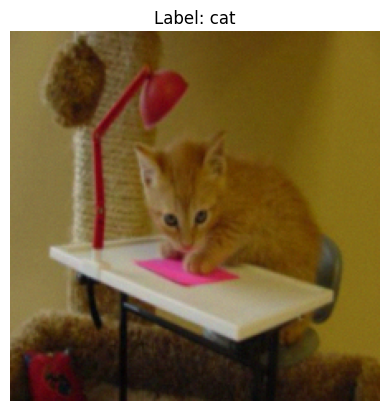

In [10]:
import matplotlib.pyplot as plt

image, label, id = train_ds[0]

# Convert tensor to numpy and transpose if needed
image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

title = "cat" if label==0 else "dog"
plt.imshow(image)
plt.title(f"Label: {title}")
plt.axis('off')
plt.show()


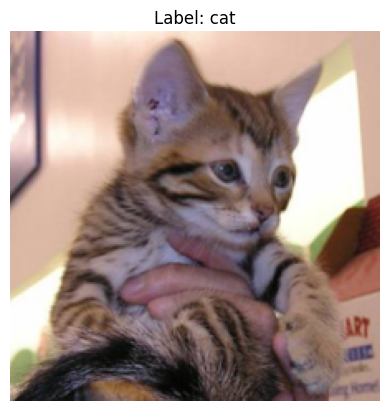

In [11]:
import matplotlib.pyplot as plt

image, label, id = val_ds[0]

# Convert tensor to numpy and transpose if needed
image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

title = "cat" if label==0 else "dog"
plt.imshow(image)
plt.title(f"Label: {title}")
plt.axis('off')
plt.show()

## Model

In [12]:
"""
An implementation of EfficientNet CNN architecture.

Programmed by Aladdin Persson <aladdin.persson at hotmail dot com>
*    2021-02-05 Initial coding
*    2022-12-20 Update comments, code revision, checked still works with latest PyTorch version
"""


import torch
import torch.nn as nn
from math import ceil

base_model = [
    # expand_ratio, channels, repeats, stride, kernel_size
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

phi_values = {
    # tuple of: (phi_value, resolution, drop_rate)
    "b0": (0, 224, 0.2),  # alpha, beta, gamma, depth = alpha ** phi
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}


class CNNBlock(nn.Module): # utilized as depthwise conv
    def __init__(
        self, in_channels, out_channels, kernel_size, stride, padding, groups=1
    ):
        super(CNNBlock, self).__init__()
        self.cnn = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            groups=groups,
            bias=False,
        )
        self.bn = nn.BatchNorm2d(out_channels)
        self.silu = nn.SiLU()  # SiLU <-> Swish

    def forward(self, x):
        return self.silu(self.bn(self.cnn(x)))


class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x) 
    # multiply each channel with the output of the sequesntial (value between 0 and 1 ) to know how each channel is prirotized
    # It allows the network to emphasize important channels and suppress less informative ones by learning a set of channel-wise weights.
    # give weight for each channel


class InvertedResidualBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        stride,
        padding,
        expand_ratio,
        reduction=4,  # squeeze excitation
        survival_prob=0.8,  # for stochastic depth
    ):
        super(InvertedResidualBlock, self).__init__()
        self.survival_prob = survival_prob
        self.use_residual = in_channels == out_channels and stride == 1 # otherwise you can't skip connection because dimensions won't match
        hidden_dim = in_channels * expand_ratio
        self.expand = in_channels != hidden_dim
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = CNNBlock(
                in_channels,
                hidden_dim,
                kernel_size=3,
                stride=1,
                padding=1,
            )

        self.conv = nn.Sequential(   # always hidden_dim would equal in_channels * expand_ratio
            CNNBlock(
                hidden_dim,
                hidden_dim,
                kernel_size,
                stride,
                padding,
                groups=hidden_dim, # depthwise convolution
            ),
            SqueezeExcitation(hidden_dim, reduced_dim),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )

    def stochastic_depth(self, x): # Regularization: It acts like dropout but for full residual layers instead of neurons.
        if not self.training:
            return x

        binary_tensor = (
            torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.survival_prob 
        )
        return torch.div(x, self.survival_prob) * binary_tensor
    
    # To randomly drop an entire residual branch per sample in the batch, not individual elements (like Dropout does). 
    # Let’s say x.shape = (B, C, H, W):
    # torch.rand(B, 1, 1, 1) creates one scalar value per sample, and broadcasts it across the entire sample (all channels, height, and width).
    # his ensures that either the whole sample is dropped (set to 0) or the entire sample is kept and scaled
    # When you drop layers this would change the mean and standard deviation so we should
    # rescale be dividing by survival_prob

    def forward(self, inputs):
        x = self.expand_conv(inputs) if self.expand else inputs
        if self.use_residual:
            return self.stochastic_depth(self.conv(x)) + inputs
        else:
            return self.conv(x)
        
        # self.stochastic_depth(self.conv(x)) Instead of always keeping the residual block during training,
        # this function randomly drops the entire residual path per sample with probability 1 - survival_prob.
        # When dropped, the block is skipped entirely for that sample.
        # When kept, its output is scaled by 1 / survival_prob to maintain the expected value (like Dropout does).


class EfficientNet(nn.Module):
    def __init__(self, version, num_classes):
        super(EfficientNet, self).__init__()
        width_factor, depth_factor, dropout_rate = self.calculate_factors(version)
        last_channels = ceil(1280 * width_factor)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.features = self.create_features(width_factor, depth_factor, last_channels)
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channels, num_classes),
        )

    def calculate_factors(self, version, alpha=1.2, beta=1.1): 
        phi, res, drop_rate = phi_values[version]
        depth_factor = alpha**phi 
        width_factor = beta**phi
        return width_factor, depth_factor, drop_rate

    def create_features(self, width_factor, depth_factor, last_channels):
        channels = int(32 * width_factor)
        features = [CNNBlock(3, channels, 3, stride=2, padding=1)] # Append first layer
        in_channels = channels

        for expand_ratio, channels, repeats, stride, kernel_size in base_model:
            out_channels = 4 * ceil(int(channels * width_factor) / 4)
            layers_repeats = ceil(repeats * depth_factor)

            for layer in range(layers_repeats):
                features.append(
                    InvertedResidualBlock(
                        in_channels,
                        out_channels,
                        expand_ratio=expand_ratio,
                        stride=stride if layer == 0 else 1,
                        kernel_size=kernel_size,
                        padding=kernel_size // 2,  # if k=1:pad=0, k=3:pad=1, k=5:pad=2
                    )
                )
                in_channels = out_channels

        features.append(
            CNNBlock(in_channels, last_channels, kernel_size=1, stride=1, padding=0) # append last layer
        )

        return nn.Sequential(*features)

    def forward(self, x):
        x = self.pool(self.features(x))
        return self.classifier(x.view(x.shape[0], -1))


def test():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    version = "b0"
    phi, res, drop_rate = phi_values[version]
    num_examples, num_classes = 32, 2
    x = torch.randn((num_examples, 3, res, res)).to(device)
    model = EfficientNet(
        version=version,
        num_classes=num_classes,
    ).to(device)

    print(model(x).shape)  # (num_examples, num_classes)


if __name__ == "__main__":
    test()


torch.Size([32, 2])


## training

In [13]:
import copy

class TrainingApp:
    def __init__(self,epochs,resume_path=None):
        self.epochs=epochs
        self.batch_size=32
        self.num_workers=2
        self.use_cuda = torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_cuda else "cpu")
        self.resume_path=resume_path
        self.model=self.initModel() 
        self.optimizer = self.initOptimizer()
        self.train_dl = self.initTrainDl()
        self.val_dl = self.initValDl()
        self.test_dl=self.initTestDl()
        self.best_model_state=None
        self.best_val_score=0
        self.best_epoch=None

        if(self.resume_path):
            self.load_state_model(path="best_model_state.pth")
            

    def initModel(self):
        model = EfficientNet(version="b0",num_classes=2)
        if self.use_cuda:
            print("Using CUDA; {} devices.".format(torch.cuda.device_count()))
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)
            model = model.to(self.device)
        return model


    def initOptimizer(self):
        #return RMSprop(self.model.parameters(), lr=1e-4, alpha=0.9)
        return Adam(self.model.parameters())

    def initTrainDl(self):
        train_ds=CustomDataset()
        batch_size=self.batch_size
        if self.use_cuda:
            batch_size *= torch.cuda.device_count()

        train_dl = DataLoader(train_ds,batch_size=batch_size,num_workers=self.num_workers,pin_memory=self.use_cuda)
        return train_dl

    def initValDl(self):
        val_ds = CustomDataset(is_val=True)
        batch_size=self.batch_size
        if self.use_cuda:
            batch_size *= torch.cuda.device_count()

        val_dl = DataLoader(val_ds,batch_size=batch_size, num_workers=self.num_workers,pin_memory=self.use_cuda)
        return val_dl

    def initTestDl(self):
        test_ds = CustomDataset(is_test=True)
        batch_size=self.batch_size
        if self.use_cuda:
            batch_size *= torch.cuda.device_count()

        test_dl = DataLoader(test_ds,batch_size=batch_size, num_workers=self.num_workers,pin_memory=self.use_cuda)
        return test_dl

    def doTraining(self, epoch_ndx):  # in one epoch
        self.model.train()
        correct = 0
        total = 0
        train_loss = 0

        self.train_dl.dataset.shuffleSamples() # shuffle samples before each epochs while training 
        for batch_idx, (data, target,_) in enumerate(self.train_dl):
            data, target = data.to(self.device).float(), target.to(self.device).long()
            self.optimizer.zero_grad()
            out = self.model(data)
            loss = F.cross_entropy(out, target)
            loss.backward()
            self.optimizer.step()

            train_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

            # Print every 50 batches
            if (batch_idx + 1) % 50 == 0:
                print(f"[Epoch {epoch_ndx} | Batch {batch_idx+1}]")

        train_acc = 100. * correct / total
        avg_train_loss = train_loss / total
        print(f"Epoch {epoch_ndx}: Avg Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.2f}%")


    def doValidation(self,epoch_ndx):
        self.model.eval()
        correct=0
        total=0
        val_loss=0
        with torch.no_grad():
            for batch_idx,(data, target,_) in enumerate(self.val_dl):
                data, target = data.to(self.device).float(), target.to(self.device).long()
                output = self.model(data)
                loss = F.cross_entropy(output, target)
                val_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

                if (batch_idx + 1) % 50 == 0:
                    print(f"[Epoch {epoch_ndx} | Batch {batch_idx+1}]")

        val_acc = 100. * correct / total
        avg_val_loss=val_loss/total
        print(f"Epoch {epoch_ndx}: "f"Avg Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.2f}% ")

        if (val_acc>self.best_val_score):
            self.best_val_score=val_acc
            self.best_model_state = copy.deepcopy(self.model.state_dict())
            self.best_epoch=epoch_ndx
            print("Best model has been updated")
            self.save_state_model()
            self.doTesting(epoch_ndx=epoch_ndx)

    def doTesting(self,epoch_ndx):
        self.model.eval()
        correct=0
        total=0
        test_loss=0
        with torch.no_grad():
            for batch_idx,(data, target,_) in enumerate(self.test_dl):
                data, target = data.to(self.device).float(), target.to(self.device).long()
                output = self.model(data)
                loss = F.cross_entropy(output, target)
                test_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

                if (batch_idx + 1) % 50 == 0:
                    print(f"[Epoch {epoch_ndx} | Batch {batch_idx+1}]")

        test_acc = 100. * correct / total
        avg_test_loss=test_loss/total
        print(f"Epoch {epoch_ndx}: "f"Avg test Loss={avg_test_loss:.4f}, test Acc={test_acc:.2f}% ")


    def main(self):
        for epoch_ndx in range(1, self.epochs+1):
            print("Epoch {} of {}, no of training batches {} / no of validation batches {} batches of size {}*{}".format(
                epoch_ndx,
                self.epochs,
                len(self.train_dl),
                len(self.val_dl),
                self.batch_size,
                (torch.cuda.device_count() if self.use_cuda else 1),
            ))

            self.doTraining(epoch_ndx=epoch_ndx)
            if(epoch_ndx%2==0):
                self.doValidation(epoch_ndx)

        # self.print_model_parameters()
        self.model.load_state_dict(self.best_model_state)
        return self.model

    def print_model_parameters(self):
        print("Model Parameters:")
        for name, param in self.model.named_parameters():
            print(f"Name: {name}, Shape: {param.shape}, Requires Grad: {param.requires_grad}")
            break
            
    def save_state_model(self, path="best_model_state.pth"):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'best_val_score': self.best_val_score,
            'best_epoch': self.best_epoch,
        }, path)
        print(f"Model has been saved to '{path}'")

    def load_state_model(self, path="best_model_state.pth"):
        print(f"Loading model state_dict from '{path}'")
        checkpoint = torch.load(path, map_location=self.device)
        self.model = self.initModel()  # reinitialize the architecture
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
    
        self.optimizer = self.initOptimizer()
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
        self.best_val_score = checkpoint.get('best_val_score', 0)
        self.best_epoch = checkpoint.get('best_epoch', None)
        print(f"Model and optimizer loaded. Best val score: {self.best_val_score}, Best epoch: {self.best_epoch}")



In [14]:
training = TrainingApp(epochs=100)
model=training.main()


Using CUDA; 1 devices.
Epoch 1 of 100, no of training batches 625 / no of validation batches 125 batches of size 32*1
[Epoch 1 | Batch 50]
[Epoch 1 | Batch 100]
[Epoch 1 | Batch 150]
[Epoch 1 | Batch 200]
[Epoch 1 | Batch 250]
[Epoch 1 | Batch 300]
[Epoch 1 | Batch 350]
[Epoch 1 | Batch 400]
[Epoch 1 | Batch 450]
[Epoch 1 | Batch 500]
[Epoch 1 | Batch 550]
[Epoch 1 | Batch 600]
Epoch 1: Avg Train Loss=0.0207, Train Acc=61.55%
Epoch 2 of 100, no of training batches 625 / no of validation batches 125 batches of size 32*1
[Epoch 2 | Batch 50]
[Epoch 2 | Batch 100]
[Epoch 2 | Batch 150]
[Epoch 2 | Batch 200]
[Epoch 2 | Batch 250]
[Epoch 2 | Batch 300]
[Epoch 2 | Batch 350]
[Epoch 2 | Batch 400]
[Epoch 2 | Batch 450]
[Epoch 2 | Batch 500]
[Epoch 2 | Batch 550]
[Epoch 2 | Batch 600]
Epoch 2: Avg Train Loss=0.0188, Train Acc=68.25%
[Epoch 2 | Batch 50]
[Epoch 2 | Batch 100]
Epoch 2: Avg Val Loss=0.0170, Val Acc=72.55% 
Best model has been updated
Model has been saved to 'best_model_state.pth'

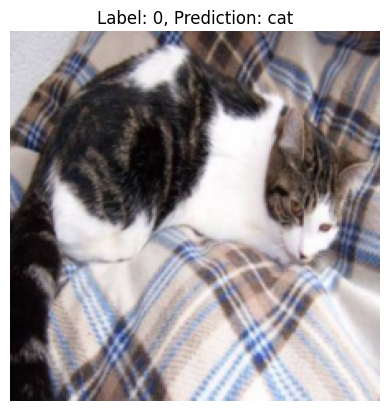

Predicted: cat
tensor([[ 3.3946, -3.3925]], device='cuda:0', grad_fn=<AddmmBackward0>)


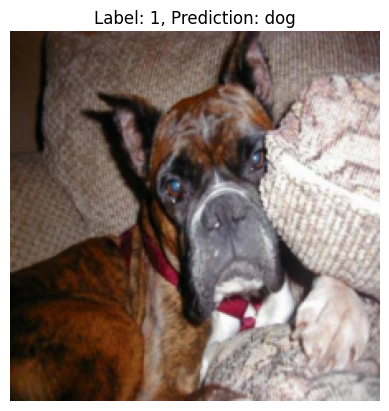

Predicted: dog
tensor([[-3.9259,  3.9309]], device='cuda:0', grad_fn=<AddmmBackward0>)


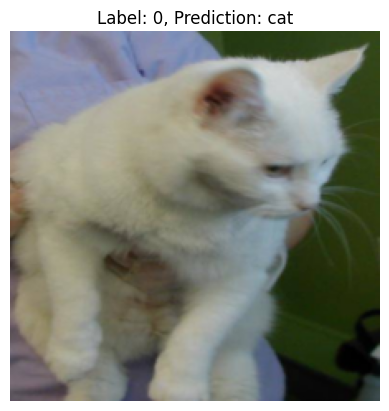

Predicted: cat
tensor([[ 0.2757, -0.2470]], device='cuda:0', grad_fn=<AddmmBackward0>)


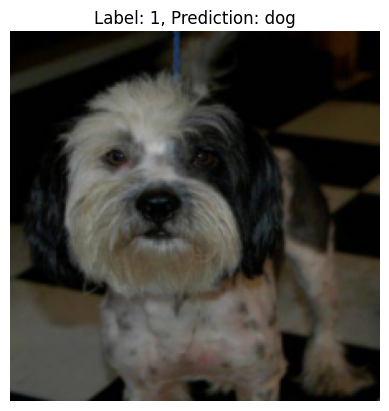

Predicted: dog
tensor([[-4.5071,  4.5091]], device='cuda:0', grad_fn=<AddmmBackward0>)


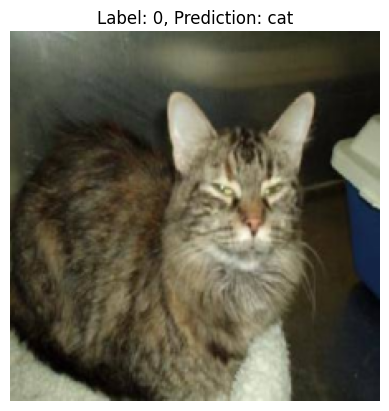

Predicted: cat
tensor([[ 6.4294, -6.4730]], device='cuda:0', grad_fn=<AddmmBackward0>)


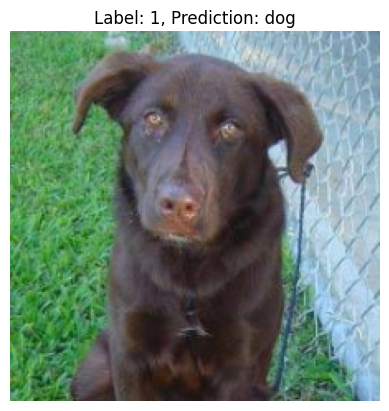

Predicted: dog
tensor([[-5.5068,  5.4997]], device='cuda:0', grad_fn=<AddmmBackward0>)


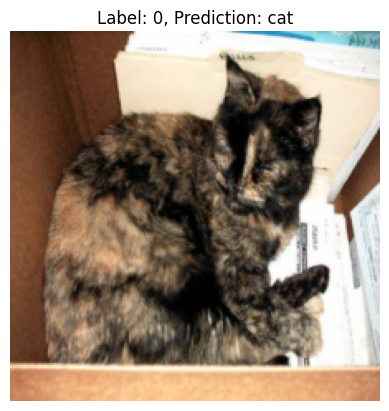

Predicted: cat
tensor([[ 2.4081, -2.3934]], device='cuda:0', grad_fn=<AddmmBackward0>)


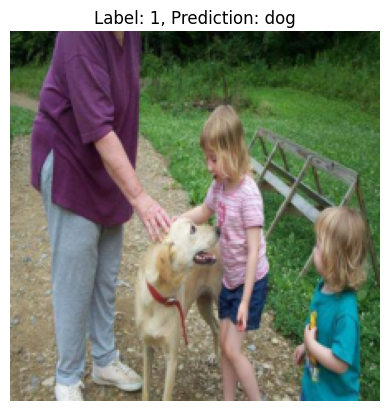

Predicted: dog
tensor([[-6.5157,  6.5013]], device='cuda:0', grad_fn=<AddmmBackward0>)


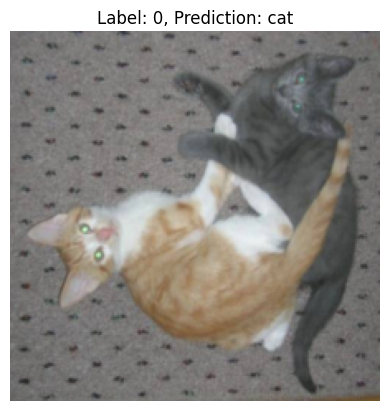

Predicted: cat
tensor([[ 2.0237, -2.0053]], device='cuda:0', grad_fn=<AddmmBackward0>)


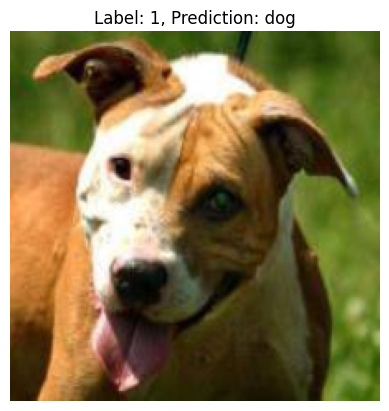

Predicted: dog
tensor([[-4.5486,  4.5499]], device='cuda:0', grad_fn=<AddmmBackward0>)


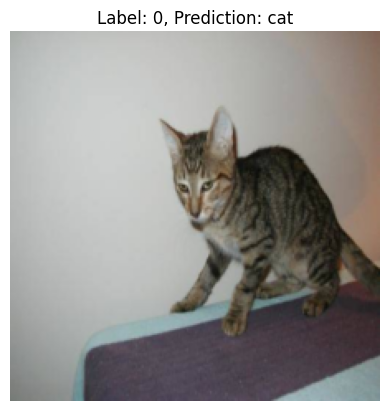

Predicted: cat
tensor([[ 4.7456, -4.7631]], device='cuda:0', grad_fn=<AddmmBackward0>)


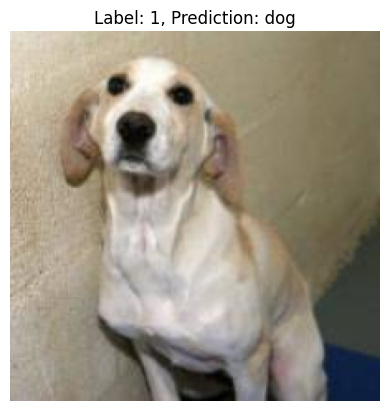

Predicted: dog
tensor([[-5.3912,  5.3849]], device='cuda:0', grad_fn=<AddmmBackward0>)


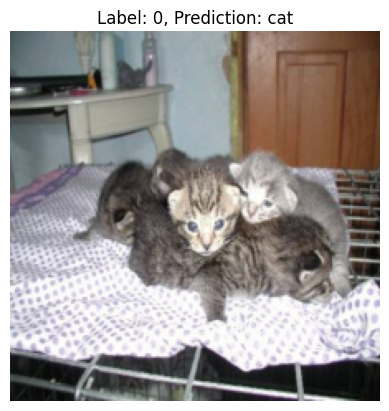

Predicted: cat
tensor([[ 5.1992, -5.2233]], device='cuda:0', grad_fn=<AddmmBackward0>)


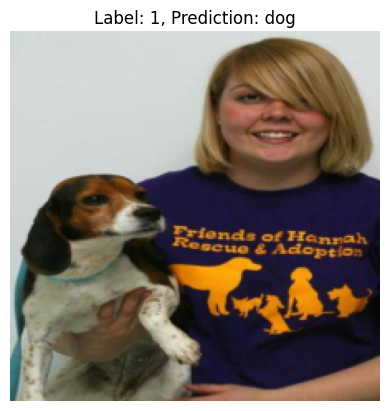

Predicted: dog
tensor([[-2.0668,  2.0864]], device='cuda:0', grad_fn=<AddmmBackward0>)


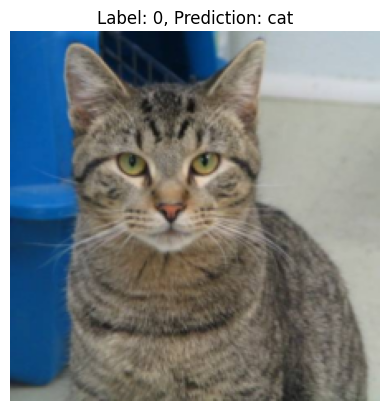

Predicted: cat
tensor([[ 5.6836, -5.7161]], device='cuda:0', grad_fn=<AddmmBackward0>)


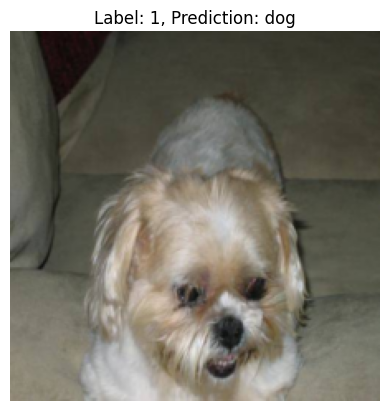

Predicted: dog
tensor([[-4.8334,  4.8341]], device='cuda:0', grad_fn=<AddmmBackward0>)


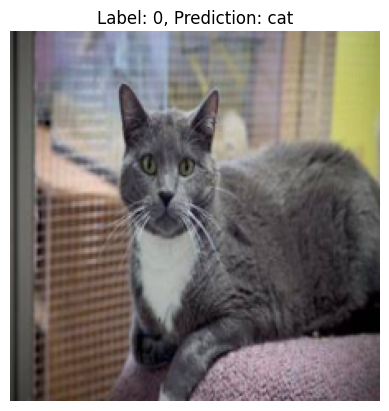

Predicted: cat
tensor([[ 5.2878, -5.3146]], device='cuda:0', grad_fn=<AddmmBackward0>)


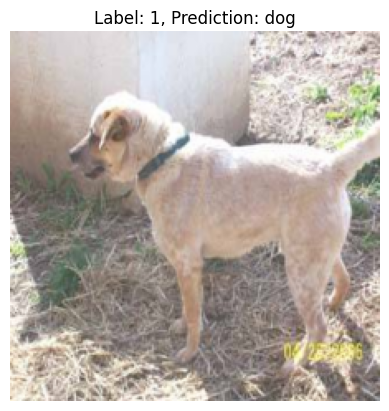

Predicted: dog
tensor([[-4.5732,  4.5733]], device='cuda:0', grad_fn=<AddmmBackward0>)


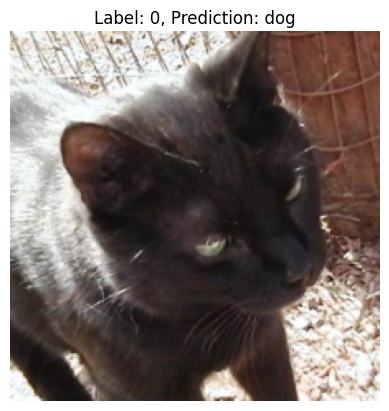

Predicted: dog
tensor([[-0.4288,  0.4572]], device='cuda:0', grad_fn=<AddmmBackward0>)


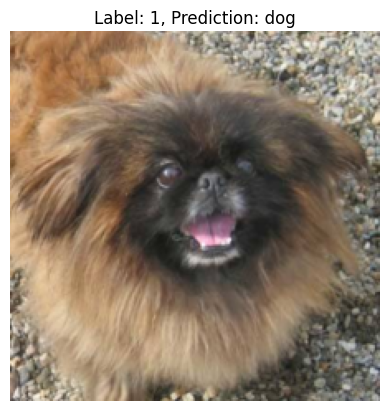

Predicted: dog
tensor([[-2.1759,  2.1904]], device='cuda:0', grad_fn=<AddmmBackward0>)


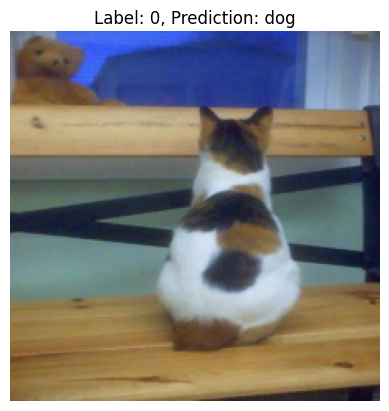

Predicted: dog
tensor([[-2.0569,  2.0756]], device='cuda:0', grad_fn=<AddmmBackward0>)


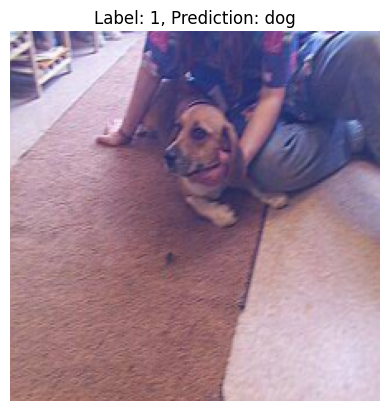

Predicted: dog
tensor([[-5.0666,  5.0623]], device='cuda:0', grad_fn=<AddmmBackward0>)


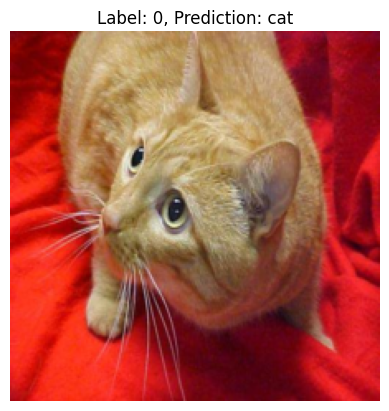

Predicted: cat
tensor([[ 1.3526, -1.3300]], device='cuda:0', grad_fn=<AddmmBackward0>)


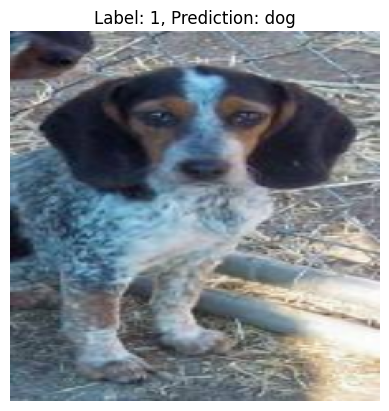

Predicted: dog
tensor([[-5.5818,  5.5750]], device='cuda:0', grad_fn=<AddmmBackward0>)


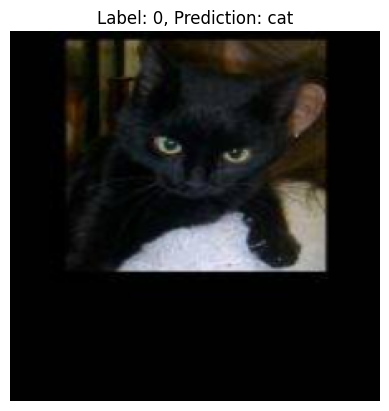

Predicted: cat
tensor([[ 4.3019, -4.3136]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [17]:
import torch
import matplotlib.pyplot as plt

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

for i in range(25):
    # Get image and label from the dataset
    image, label, img_id = test_ds[i]

    # Move the image to the device of the model
    image = image.to(device)

    # Add a batch dimension
    image_batch = image.unsqueeze(0)

    # Make a prediction
    output = model(image_batch)
    prediction = output.argmax(dim=1)

    #if(label == prediction):
     #   continue
    title = "cat" if prediction==0 else "dog"

    # Convert tensor to numpy and rearrange dimensions for RGB display
    img_np = image.cpu().permute(1, 2, 0).numpy()  # (C, H, W) -> (H, W, C)

    # Plot the RGB image
    plt.imshow(img_np)
    plt.title(f"Label: {label}, Prediction: {title}")
    plt.axis('off')
    plt.show()

    print(f"Predicted: {title}")
    print(output)
